# Time series - binary classification
The following example shows binary classification task on time series data. There are several approaches possible. We will try two of them:

- **Feedforward neural network** fixed window training & prediction
- **Recurrent neural network** fixed window training & continuous prediction

The task is to classify (detect) a jump performed by a trampoline jumper during her training. We would classify a specific jump (called twist - backflip with one spin) from the other jumps.

First, we need some imports. We won't use `pandas` for this example, just `numpy`:

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt

%matplotlib inline

## Dataset preparation
Dataset consist of several hundreds of timeseries. It's separated into two folders, the first contains *positive samples* - twists, and the other contains *negative samples* - other jumps.

Eeach jump is captured in a CSV file that contains 13 values per time step.

In [2]:
def read_csv_files(path):
    dirpath, dirnames, filenames = list(os.walk(path))[0]    
    return [
        np.genfromtxt(dirpath + '/' + file, delimiter=',') for file in filenames 
        if os.path.splitext(file)[1] == '.csv'
    ]

In [3]:
DATA_FOLDER = '../data/trampoliny/'

positive_samples = read_csv_files(DATA_FOLDER + '42')
negative_samples = read_csv_files(DATA_FOLDER + 'ostatni')

There are several hundreads of samples in the datasets. Their lengths vary from ~20 to ~120 timesteps.

Positive samples: 600
Negative samples: 450


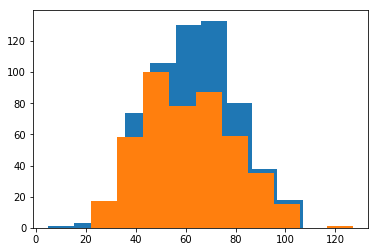

In [4]:
print("Positive samples: %d" % len(positive_samples))
print("Negative samples: %d" % len(negative_samples))
plt.hist([len(x) for x in positive_samples])
plt.hist([len(x) for x in negative_samples])
plt.show()

### Columns selection
Data were captured using a motion sensor attached to the jumper's leg during her training. The motion sensor can give us several quantities:

- linear acceleration (3D vector)
- angual acceleration (3D vector)
- direction of gravity (3D sensor)
- orientation (4D quaternion)

Quantities are captured in different frequencies and all dataset was resampled to the the same frequency using nearies neighbour resampling (see "steps" in the plotted curves).

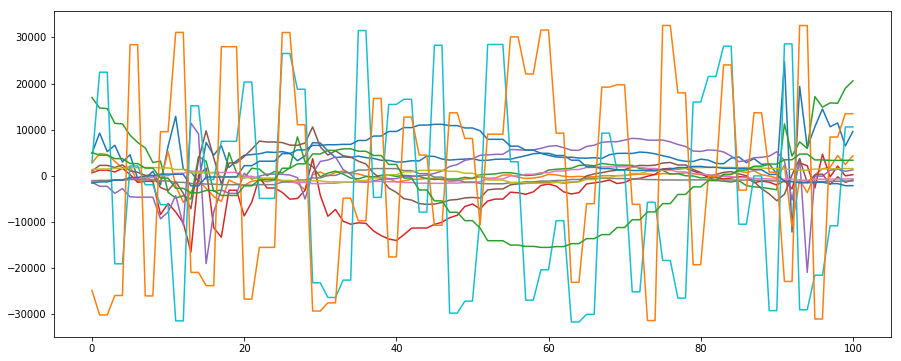

In [5]:
plt.figure(figsize=(15,6))
plt.plot(positive_samples[0])
plt.show()

Orientation values seems to vary a lot, let's ignore them for the training. (We can keep them there but the model would probably ignore them anyway)

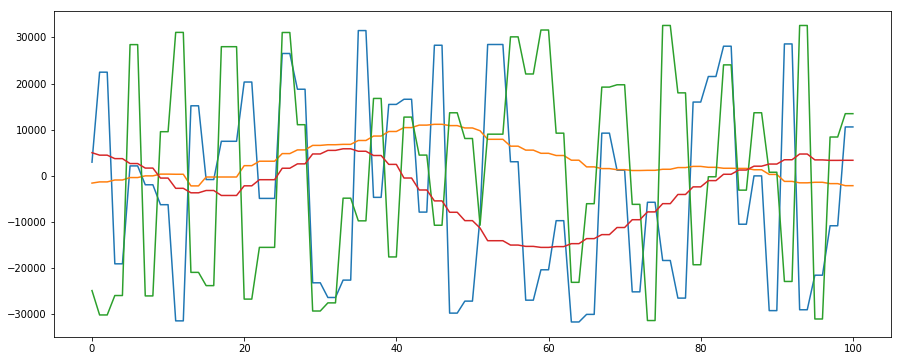

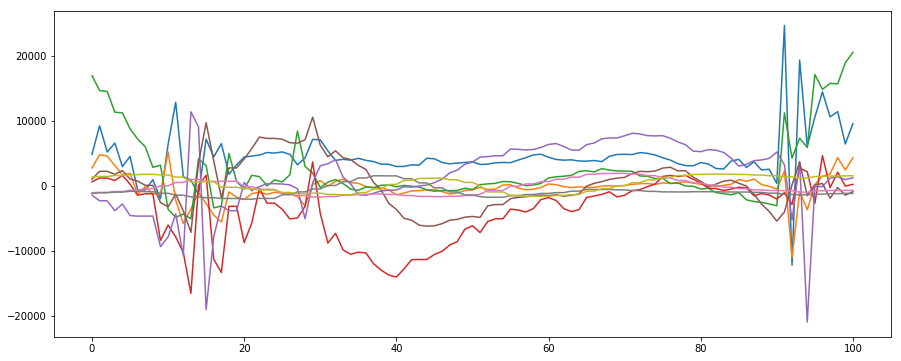

In [6]:
plt.figure(figsize=(15,6))
plt.plot(positive_samples[0][:,9:13])
plt.show()

plt.figure(figsize=(15,6))
plt.plot(positive_samples[0][:,0:9])
plt.show()

### Normalization & padding
The values returned the sensor is given by it's digital nature (usually between -32k, 32k) and needs to be normalized (column-wise).

In [7]:
def normalize(*datasets):            
    all_samples = np.vstack([np.vstack(samples) for samples in datasets])    
    max_vals = np.max(all_samples, axis=0)
    min_vals = np.min(all_samples, axis=0)
    
    return [
        [(sample - min_vals) / (max_vals - min_vals) * 2 - 1 for sample in samples] 
        for samples in datasets
    ], min_vals, max_vals

In [8]:
(norm_positive_samples, norm_negative_samples), max_vals, min_vals = normalize(positive_samples, negative_samples)

Also, for tensor-based training, the data need to be padded to a fixed length. Let's take the maximum length and pad all sequences with zeros (leading).

In [9]:
from keras.preprocessing.sequence import pad_sequences

def pad(*datasets):
    max_length = max(sample.shape[0] for samples in datasets for sample in samples)
    return [pad_sequences(samples, maxlen=max_length, dtype=datasets[0][0].dtype) for samples in datasets]

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


..now, let's see how our samples look like after normalization and padding

In [10]:
norm_positive_samples, norm_negative_samples = pad(norm_positive_samples, norm_negative_samples)

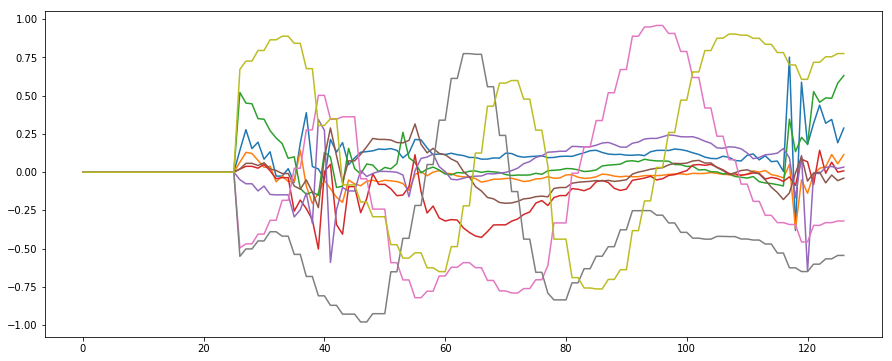

In [11]:
plt.figure(figsize=(15,6))
plt.plot(norm_positive_samples[0][:,0:9])
plt.show()

## Model training
Now, we are ready to train the model. Let§s start with training set construction

Notice how we are creating the target variable by filling correct number of *zeroes* and *ones* into the `training_Y` array.

In [12]:
training_X = np.vstack((norm_positive_samples[:,:,0:9], norm_negative_samples[:,:,0:9]))
training_Y = np.vstack((np.full((len(positive_samples), 1), 1.0), np.full((len(negative_samples), 1), 0.0)))

We wan't to use `validation_split` and we need to shuffle the training set randomly. It needs to be performed "pair-wise".

In [13]:
import random
training_set = list(zip(training_X, training_Y))
random.shuffle(training_set)

training_X, training_Y = zip(*training_set)
                             
training_X = np.array(training_X)
training_Y = np.array(training_Y)

### Feed-forward model
Let's start with the simple **feed-forward network** with no recurrent connections. 

In this case, we need to reshape out input data as we are feeding it all together in one step (127x9 values)

In [17]:
from keras import Model
from keras.layers import LSTM, Input, Dense

inputs = Input(shape=(training_X.shape[1] * training_X.shape[2],))
x = Dense(256, activation='tanh')(inputs)
x = Dense(128, activation='tanh')(x)
x = Dense(64, activation='tanh')(x)
outputs = Dense(1, activation='sigmoid')(x)

ffn_model = Model(inputs, outputs)
ffn_model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
ffn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1143)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               292864    
_________________________________________________________________
dense_6 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_7 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 334,081
Trainable params: 334,081
Non-trainable params: 0
_________________________________________________________________


In [15]:
ffn_training_X = training_X.reshape(training_X.shape[0], training_X.shape[1] * training_X.shape[2])

In [18]:
ffn_model.fit(ffn_training_X, training_Y, epochs=40, validation_split=0.1)

Train on 945 samples, validate on 105 samples
Epoch 1/40
945/945 [==============================] - 0s 233us/step - loss: 0.5503 - acc: 0.7185 - val_loss: 0.4992 - val_acc: 0.7429
Epoch 2/40
945/945 [==============================] - 0s 133us/step - loss: 0.3577 - acc: 0.8497 - val_loss: 0.4288 - val_acc: 0.7714
Epoch 3/40
945/945 [==============================] - 0s 136us/step - loss: 0.2537 - acc: 0.9058 - val_loss: 0.4128 - val_acc: 0.7905
Epoch 4/40
945/945 [==============================] - 0s 135us/step - loss: 0.1747 - acc: 0.9492 - val_loss: 0.3708 - val_acc: 0.8476
Epoch 5/40
945/945 [==============================] - 0s 133us/step - loss: 0.1290 - acc: 0.9598 - val_loss: 0.4811 - val_acc: 0.7714
Epoch 6/40
945/945 [==============================] - 0s 133us/step - loss: 0.0836 - acc: 0.9757 - val_loss: 0.3876 - val_acc: 0.8571
Epoch 7/40
945/945 [==============================] - 0s 130us/step - loss: 0.0462 - acc: 0.9926 - val_loss: 0.4004 - val_acc: 0.8762
Epoch 8/40
945/9

We finished with ~90% accuracy on the validation set.

We can do better with recurrent nets. Both better accuracy and much smaller model.

### LSTM recurrent model

Let's take famous LSTM units and make smaller 2-layered network out of them. 

Notice the shape of the input. LSTMs are recurrent networds and they expects sequences of inputs):

In [19]:
inputs = Input(shape=training_X.shape[1:])
x = LSTM(64, return_sequences=True, recurrent_activation='sigmoid')(inputs)
x = LSTM(64, recurrent_activation='sigmoid')(x)
outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs, outputs)
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 127, 9)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 127, 64)           18944     
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 65        
Total params: 52,033
Trainable params: 52,033
Non-trainable params: 0
_________________________________________________________________


In [20]:
model.fit(training_X, training_Y, epochs=30, validation_split=0.1)
model.save_weights('model_trampoline_9i.hdf')

Train on 945 samples, validate on 105 samples
Epoch 1/30
945/945 [==============================] - 3s 3ms/step - loss: 0.5805 - acc: 0.6825 - val_loss: 0.5207 - val_acc: 0.7333
Epoch 2/30
945/945 [==============================] - 2s 2ms/step - loss: 0.4724 - acc: 0.7714 - val_loss: 0.4132 - val_acc: 0.7714
Epoch 3/30
945/945 [==============================] - 2s 2ms/step - loss: 0.4236 - acc: 0.8180 - val_loss: 0.3842 - val_acc: 0.8095
Epoch 4/30
945/945 [==============================] - 2s 2ms/step - loss: 0.3830 - acc: 0.8360 - val_loss: 0.3676 - val_acc: 0.8000
Epoch 5/30
945/945 [==============================] - 2s 2ms/step - loss: 0.3553 - acc: 0.8339 - val_loss: 0.3440 - val_acc: 0.9048
Epoch 6/30
945/945 [==============================] - 2s 2ms/step - loss: 0.3063 - acc: 0.8751 - val_loss: 0.3285 - val_acc: 0.8476
Epoch 7/30
945/945 [==============================] - 2s 2ms/step - loss: 0.2624 - acc: 0.8921 - val_loss: 0.6782 - val_acc: 0.6667
Epoch 8/30
945/945 [==========

We finished with >90% accuracy on the validation set.
### Predicion phase

Now, let's build the prediction model. We will use the same architecture (LSTMs) but now we are aiming for continuous prediction (return output value for each timestep).

In [21]:
from keras import Model
from keras.layers import LSTM, Input, Dense, Dropout

inputs = Input(shape=(None, training_X.shape[2]))
x = LSTM(64, return_sequences=True, recurrent_activation='sigmoid')(inputs)
x = LSTM(64, return_sequences=True, recurrent_activation='sigmoid')(x)
outputs = Dense(1, activation='sigmoid')(x)

cont_model = Model(inputs, outputs)
cont_model.summary()
cont_model.load_weights("model_trampoline_9i.hdf")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, None, 9)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, None, 64)          18944     
_________________________________________________________________
lstm_4 (LSTM)                (None, None, 64)          33024     
_________________________________________________________________
dense_10 (Dense)             (None, None, 1)           65        
Total params: 52,033
Trainable params: 52,033
Non-trainable params: 0
_________________________________________________________________


Let's see how the network works throughout the whole sequence:

In [22]:
def show_prediction(test_case):
    print(test_case[1])

    c_prediction = cont_model.predict(np.expand_dims(test_case[0], axis=0))
    plt.figure(figsize=(15,6))
    plt.plot(test_case[0], 'silver')
    plt.plot(c_prediction[0], 'red' if test_case[1] == 0 else 'green')
    plt.show()

[1.]


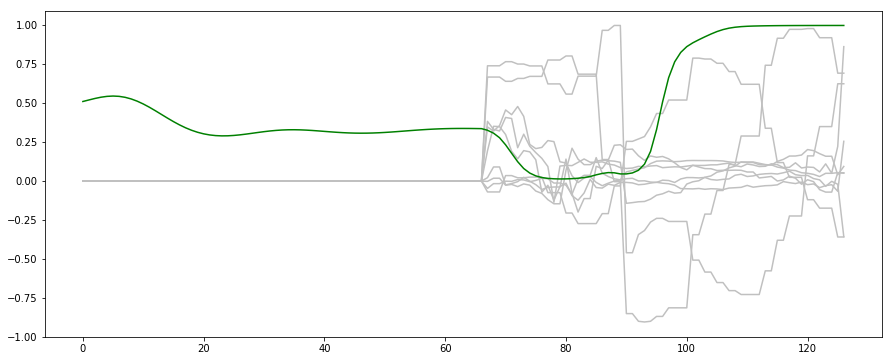

[0.]


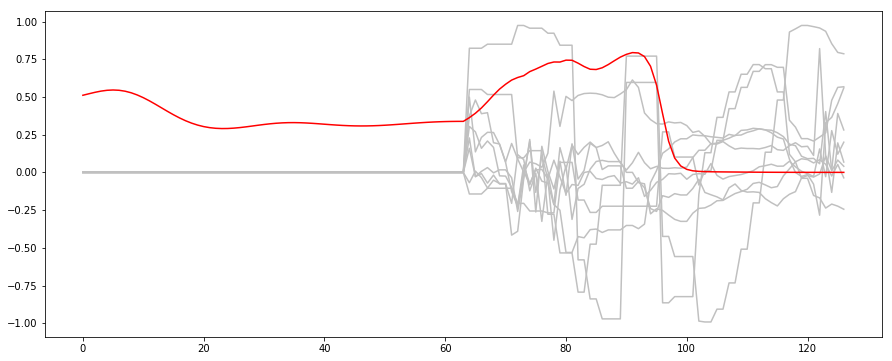

In [34]:
positive_test_sample = next(sample for sample in reversed(training_set) if sample[1] == 1)
negative_test_sample = next(sample for sample in reversed(training_set) if sample[1] == 0)

show_prediction(positive_test_sample)
show_prediction(negative_test_sample)

The LSTM prediction model is not restricted to a fixed sequence length and can predict for arbitrary sequence length:

1


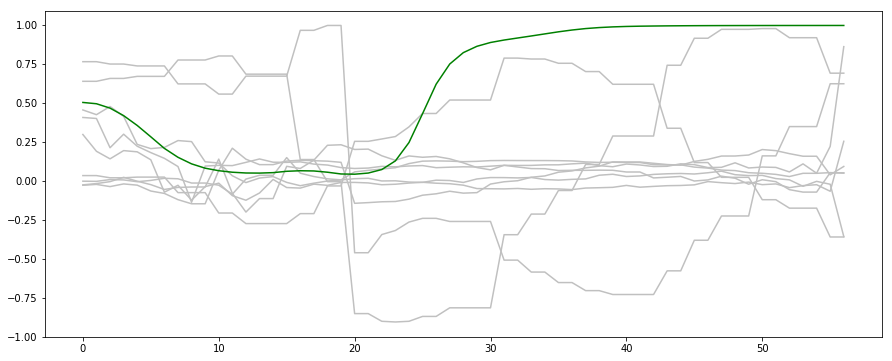

0


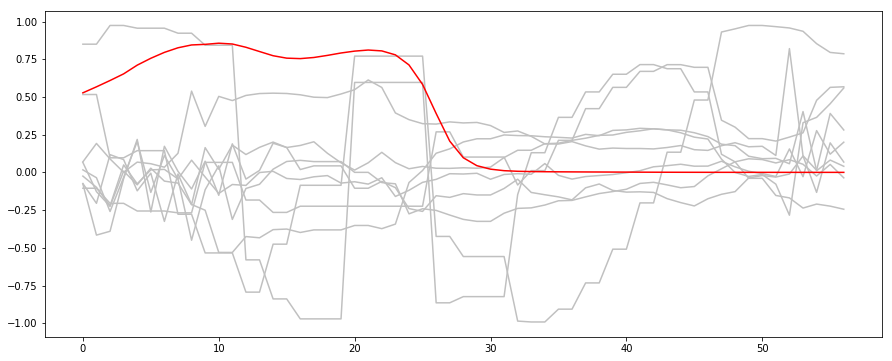

In [38]:
show_prediction((positive_test_sample[0][70:], 1))
show_prediction((negative_test_sample[0][70:], 0))

## Analysis

Let's make some analysis on the whole dataset and finish our experiment with standard performance measures.

First, let's see how our model perform on various sequence lengths:

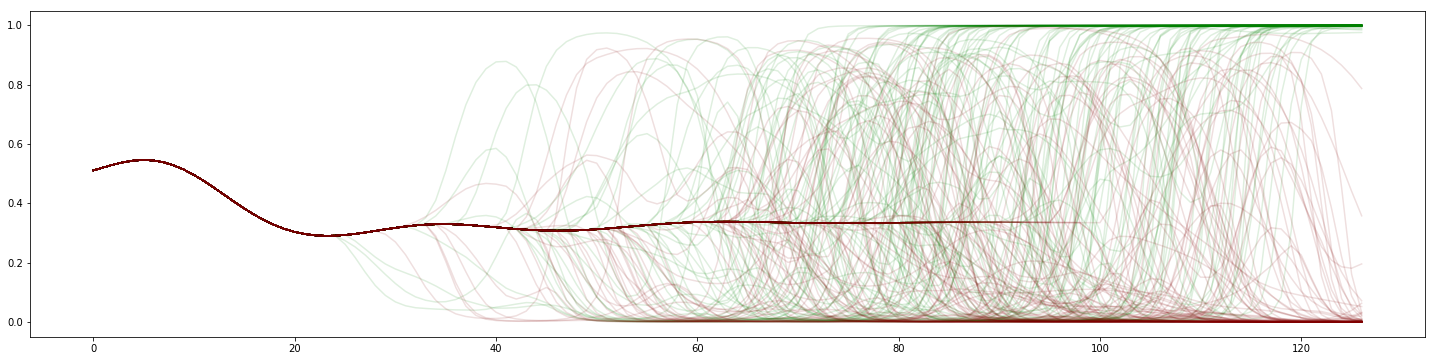

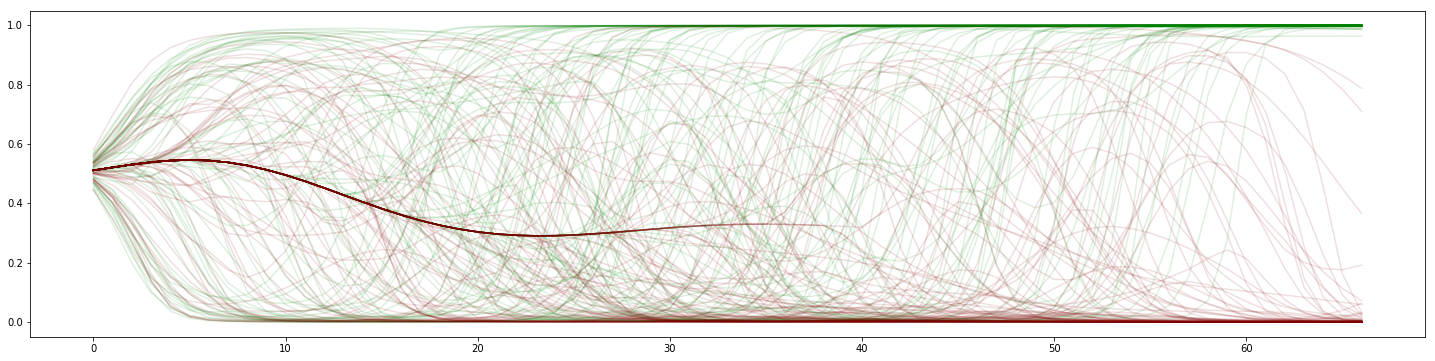

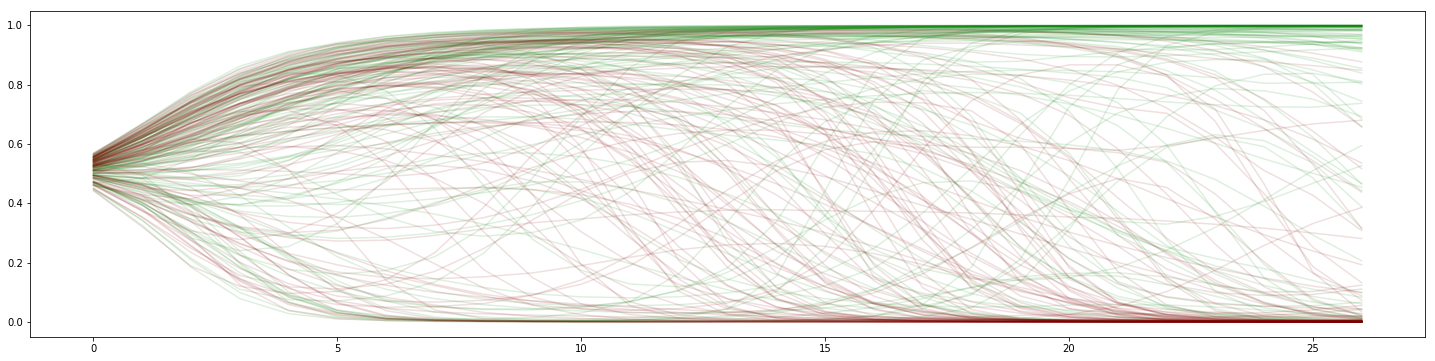

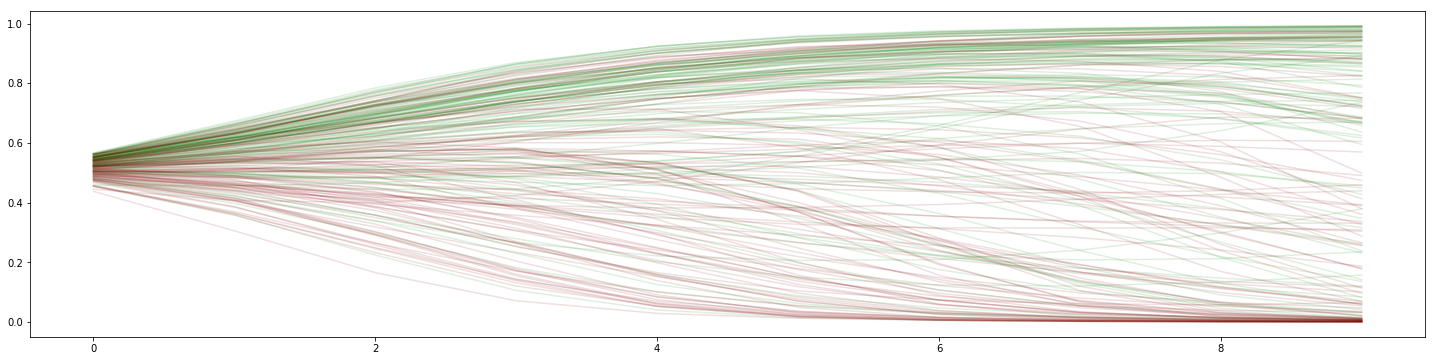

In [39]:
plt.figure(figsize=(25,6))
c_prediction = cont_model.predict(norm_positive_samples[:100,:,0:9])
plt.plot(np.squeeze(c_prediction).T, '#00800020')
c_prediction = cont_model.predict(norm_negative_samples[:100,:,0:9])
plt.plot(np.squeeze(c_prediction).T, '#80000020')
plt.show()

plt.figure(figsize=(25,6))
c_prediction = cont_model.predict(norm_positive_samples[:100,60:,0:9])
plt.plot(np.squeeze(c_prediction).T, '#00800020')
c_prediction = cont_model.predict(norm_negative_samples[:100,60:,0:9])
plt.plot(np.squeeze(c_prediction).T, '#80000020')
plt.show()

plt.figure(figsize=(25,6))
c_prediction = cont_model.predict(norm_positive_samples[:100,100:,0:9])
plt.plot(np.squeeze(c_prediction).T, '#00800020')
c_prediction = cont_model.predict(norm_negative_samples[:100,100:,0:9])
plt.plot(np.squeeze(c_prediction).T, '#80000020')
plt.show()

plt.figure(figsize=(25,6))
c_prediction = cont_model.predict(norm_positive_samples[:100,117:,0:9])
plt.plot(np.squeeze(c_prediction).T, '#00800020')
c_prediction = cont_model.predict(norm_negative_samples[:100,117:,0:9])
plt.plot(np.squeeze(c_prediction).T, '#80000020')
plt.show()

Finally let's see what would be the optimal threshold for application of our model:

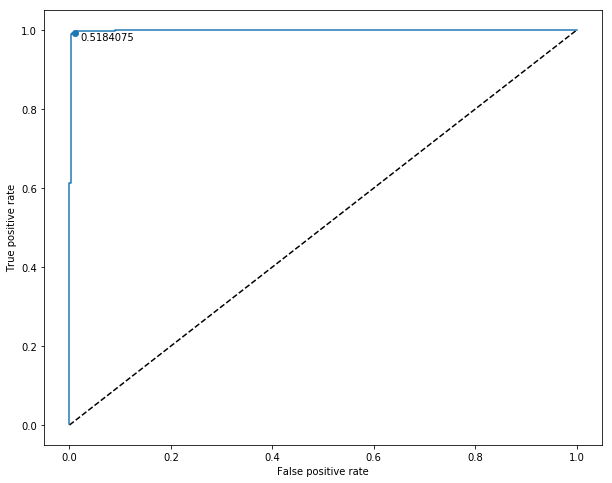

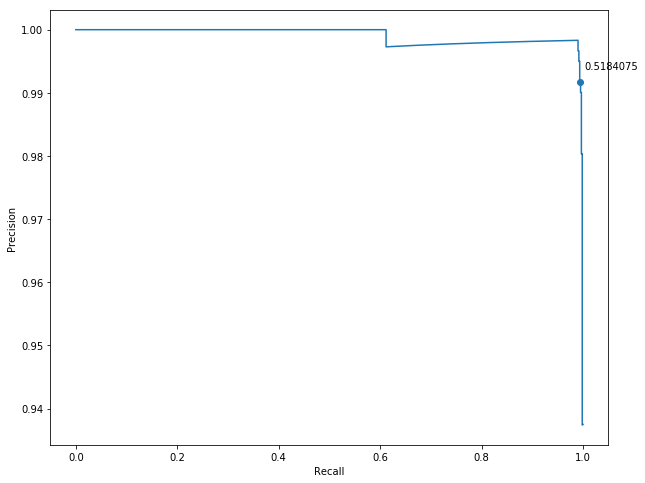

In [45]:
from sklearn.metrics import roc_curve, precision_recall_curve

threshold = 0.5

validation_X = training_X[:]
validation_Y = training_Y[:]

validation_prediction = cont_model.predict(validation_X)[:,-1]

fpr, tpr, thresholds = roc_curve(validation_Y, validation_prediction)

fig = plt.figure(figsize=(10, 8))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)

t_index = min(enumerate(thresholds), key=lambda x: abs(x[1] - threshold))[0]
s = plt.scatter(fpr[t_index], tpr[t_index])
s.axes.annotate(thresholds[t_index], (fpr[t_index] + 0.01, tpr[t_index] - 0.02))

    
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

precision, recall, thresholds = precision_recall_curve(validation_Y, validation_prediction)

fig = plt.figure(figsize=(10, 8))
plt.plot(recall, precision)

t_index = min(enumerate(thresholds), key=lambda x: abs(x[1] - threshold))[0]
s = plt.scatter(recall[t_index], precision[t_index])
s.axes.annotate(thresholds[t_index], (recall[t_index] + 0.01, precision[t_index] + 0.002))

plt.xlabel('Recall')    
plt.ylabel('Precision')
plt.show()

In [46]:
from sklearn.metrics import confusion_matrix

confusion_matrix(validation_Y, [0 if x < threshold else 1 for x in validation_prediction])

array([[445,   5],
       [  4, 596]])